# Single Layer (1 hidden, 1 output) Diagonal ReLU Recurrent Network (Pachitariu 2013) to sMNIST/rowMNIST

## Organisation 

<ol type="a">
    <li>ReLU RNN (from paper)</li>
    <li>Smooth ReLU RNN (from paper)</li>
    <li>Skip RNN (from paper)</li>
    <li><p style="font-weight:bold;">Diagonal reccurent weights ReLU RNN (my intermediary step)  <font color='red'>THIS NOTEBOOK</font></p></li>
    <li>Diagonal reccurent weights Linear RNN (from paper, named IRLM)</li>
    <li>Multi layer: Diagonal reccurent weights (my extension)</li>
</ol>

## Equations
The recurrent weights are now diagonal matrices, which means we can do hadamard products instead of matrix multiplications. These weights are sampled uniformly between -0.999 and 0.999 to ensure that the eigenvalues are less than 1. 

The input and output weights are still dense matrices sampled using LeCun normal initialization.

All biases are initialized to zero.

Initialization:

$
W_{hx} \in \mathbb{R}^{n_h \times n_x} \text{ with } W_{hx} \text{ sampled } \sim \mathcal{N}(0, \sqrt{\frac{1}{n_x}}) \\
\vec{w}_{hh} \in \mathbb{R}^{n_h} \text{ with } \vec{w}_{hh} \text{ sampled } \sim \mathcal{U}(0.999, -0.999) \\
\vec{b}_h \in \mathbb{R}^{n_h} \\
W_{hy} \in \mathbb{R}^{n_y \times n_h} \text{ with } W_{hy} \text{ sampled } \sim \mathcal{N}(0, \sqrt{\frac{1}{n_h}}) \\
\vec{b}_o \in \mathbb{R}^{n_y} \\
$


State update:

$
\vec{h}_t = \text{ReLU}(W_{hx}\vec{x}_t + \vec{w}_{hh}\odot\vec{h}_{t-1} + \vec{b}_h) \text{ with }\vec{h}_t \in \mathbb{R}^{n_h} \text{ and } \vec{x}_t \in \mathbb{R}^{n_x} \\
$

Output: mean of output over time (or cummulative sum of output over time):

$
\vec{o}_t = W_{hy}\vec{h}_t + \vec{b}_o \\
\vec{o} = \frac{1}{T}\sum_{t=1}^{T}\vec{o}_t \\
\vec{y} = \text{softmax}(\vec{o}) \\
$

<font color='green'>THINGS SOLVED</font>
- exploding activations --> change the recurrent weight initialization to ensure |w| < 1 

<font color='red'>THINGS TO UNDERSTAND</font>
- why init in glorot using (256,) does not work? --> my own init function
- understand why getting the params in the layers doesn't work
- understand why not running on GPU


In [1]:
!pwd
!which python
!pip freeze | grep -E 'flax|jax|orbax|optax'

/home/tristan/LearningJAX/Flax
/home/tristan/miniconda3/envs/.jax_conda_env_LearningJAX/bin/python
flax==0.8.0
jax==0.4.25
jaxlib==0.4.25+cuda11.cudnn86
optax==0.1.8
orbax-checkpoint==0.5.0


In [2]:
import jax
import numpy as np
import torch
from jax import numpy as jnp
from torch.utils.data import TensorDataset
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
from flax import linen as nn
from flax.training import train_state
import optax
from jax.nn.initializers import lecun_normal
from typing import Any, Tuple, Sequence, Optional
import matplotlib.pyplot as plt
px = 1 / plt.rcParams['figure.dpi']

jnp.set_printoptions(precision=3, suppress=True)

# set cuda visible devices
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from utils import create_mnist_classification_dataset, plot_dynamics

In [4]:
DATASET_VERSION = "sequential" # "row"
trainloader, val_loader, testloader, N_CLASSES, SEQ_LENGTH, IN_DIM = create_mnist_classification_dataset(root="../data", version=DATASET_VERSION)

[*] Generating MNIST Classification Dataset...


In [5]:
batch_x, batch_y = next(iter(testloader))
print(batch_x.shape, batch_y.shape)
print(batch_y.dtype)

(128, 784, 1) (128,)
int64


In [6]:
from typing import Sequence

def rec_initializer():
    def init(key, shape):
        return jax.random.uniform(key, shape, minval=-0.999, maxval=0.999)
    return init

class IRLMLayer(nn.Module):
    hidden_size: int
    out_size: int

    def setup(self):
        self.Linear_in = nn.Dense(self.hidden_size, name='Whx')
        self.wh = self.param('wh', rec_initializer(), (self.hidden_size,))
    

    def __call__(self, x):
        def update(self, h, x):
            # Wh @ h + Wx @ x + b can be efficiently computed
            # by concatenating the vectors and then having a single dense layer
            xb = self.Linear_in(x)
            decayed_state = self.wh * h
            new_state = jax.nn.relu(xb + decayed_state)
            return new_state, new_state

        scan_update = nn.scan(
            update,
            variable_broadcast='params',
            split_rngs={'params': False},
            in_axes=0,
            out_axes=0,
        )
        h = jnp.zeros((self.hidden_size,))
        _, state_hist = scan_update(self, h, x)
        return state_hist

class RNNBackbone(nn.Module):
    hidden_size: int
    output_size: int
    n_layers: int

    def setup(self):
        self.rnn_cells = [IRLMLayer(self.hidden_size, self.output_size) for _ in range(self.n_layers)]
        self.readout = nn.Dense(self.output_size, name='readout')
    def __call__(self, x):
        # print(x.shape)
        all_state_hist = []
        for id_layer, rnn_cell in enumerate(self.rnn_cells[:-1]):
            x = rnn_cell(x)
            all_state_hist.append(x)
        state_hist = self.rnn_cells[-1](x)
        all_state_hist.append(state_hist)
        out_hist = self.readout(state_hist)
        return all_state_hist, out_hist
    
BatchRNN = nn.vmap(RNNBackbone, in_axes=0, out_axes=0, variable_axes={'params': None}, split_rngs={'params': False})


In [7]:
model = BatchRNN(256, 10, 1)
params = model.init(jax.random.PRNGKey(0), jnp.zeros_like(batch_x[:5]))
all_state_hist, out_hist = model.apply(params, batch_x[:5])
print(len(all_state_hist), [all_state_hist[i].shape for i in range(len(all_state_hist))], out_hist.shape) # (batch, time, cell_size)
y = out_hist.mean(axis=1)
print(y.shape)
assert y.shape == (5, 10)
print(y)

1 [(5, 784, 256)] (5, 784, 10)
(5, 10)
[[ 1.351 -0.768  2.109 -2.111 -2.607  2.286  2.696  1.736  2.407  0.888]
 [ 1.329 -0.746  1.855 -1.739 -2.34   1.988  2.486  1.512  2.386  0.808]
 [ 1.378 -0.794  2.31  -2.415 -2.83   2.528  2.852  1.928  2.454  0.965]
 [ 1.324 -0.683  1.652 -1.473 -2.087  1.732  2.313  1.315  2.332  0.686]
 [ 1.311 -0.736  2.08  -2.132 -2.56   2.253  2.613  1.724  2.341  0.859]]


In [8]:
one_hot = jax.nn.one_hot(batch_y[:5], 10)
loss = optax.softmax_cross_entropy(logits=y, labels=one_hot)
print(loss.shape)
print(loss)
print(loss.mean())


(5,)
[2.3   2.013 4.978 2.404 6.548]
3.6485794


In [9]:
print('\nparams: \n', jax.tree_util.tree_map(jnp.shape, params['params']))


params: 
 {'readout': {'bias': (10,), 'kernel': (256, 10)}, 'rnn_cells_0': {'Whx': {'bias': (256,), 'kernel': (1, 256)}, 'wh': (256,)}}


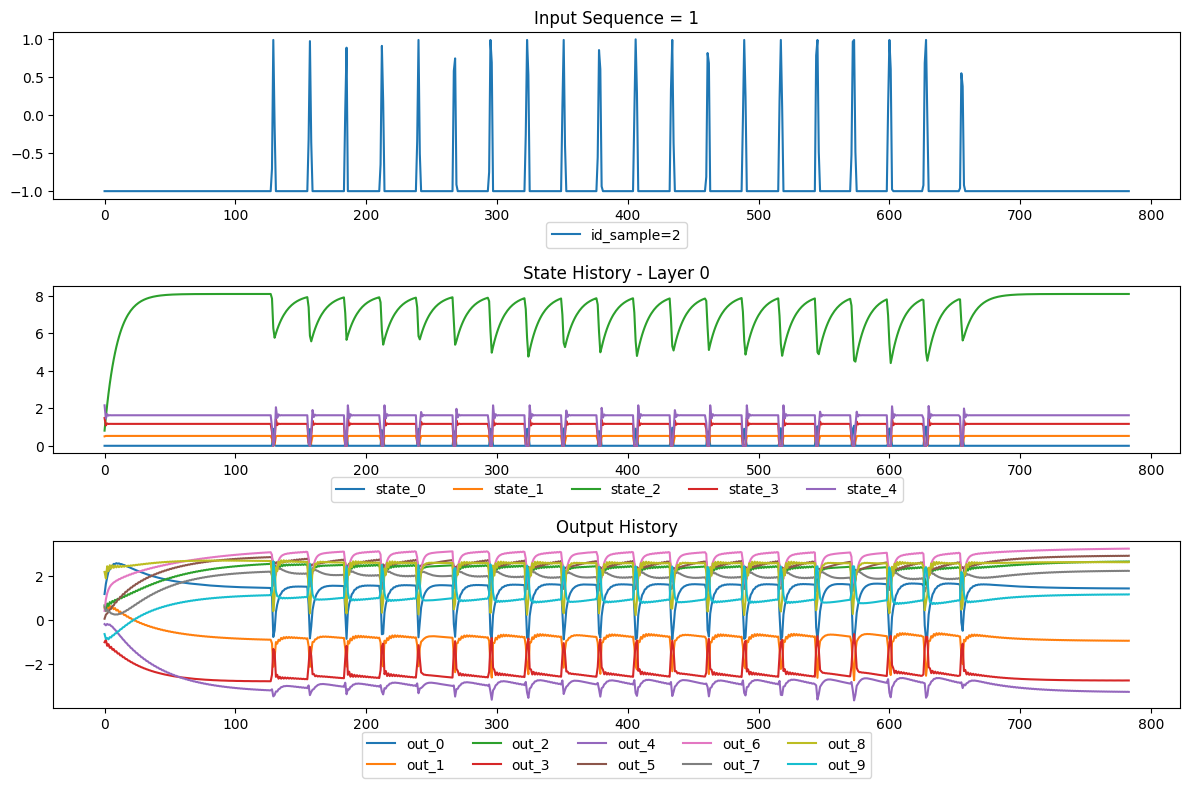

In [10]:
plot_dynamics(model, params, batch_x, batch_y, dataset_version=DATASET_VERSION, id_sample=2)

In [11]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
lr = 1e-3

In [12]:
@jax.jit
def update_model(state, grads):
    return state.apply_gradients(grads=grads)

In [13]:
@jax.jit
def apply_model(state, images, labels):
    """Computes gradients, loss and accuracy for a single batch."""

    def loss_fn(params):
        _, out_hist = state.apply_fn({'params': params}, images)
        logits = out_hist.mean(axis=1)
        one_hot = jax.nn.one_hot(labels, 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return grads, loss, accuracy
    

In [14]:
def run_epoch(state, train_dl, rng):
    """Train for a single epoch."""

    epoch_loss = []
    epoch_accuracy = []

    progress_bar = tqdm(train_dl, desc="Training", leave=True)
    batch_id = 0
    for batch_images, batch_labels in progress_bar:
        grads, loss, accuracy = apply_model(state, batch_images, batch_labels)
        # print(jnp.max(grads['dense_0']['kernel']), jnp.min(grads['dense_0']['kernel']))
        # print(loss)
        state = update_model(state, grads)
        epoch_loss.append(loss)
        epoch_accuracy.append(accuracy)
        batch_id += 1
        if batch_id % 3 == 0:
            progress_bar.set_postfix(loss=loss.item(), accuracy=accuracy.item())
        
    train_loss = np.mean(epoch_loss)
    train_accuracy = np.mean(epoch_accuracy)
    return state, train_loss, train_accuracy


In [15]:
@jax.jit
def eval_model(state, images, labels):
    """Computes gradients, loss and accuracy for a single batch."""

    def loss_fn(params):
        _, out_hist = state.apply_fn({'params': params}, images)
        logits = out_hist.mean(axis=1)
        one_hot = jax.nn.one_hot(labels, 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits

    loss, logits = loss_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return loss, accuracy

In [16]:
def validate(state, testloader):
    # Compute average loss & accuracy
    # model = model(training=False) # needed when using dropout
    losses, accuracies = [], []
    for batch_idx, (inputs, labels) in enumerate(testloader):
        loss, acc = eval_model(
            state, inputs, labels # from S4D: , model, classification=classification
        )
        losses.append(loss)
        accuracies.append(acc)
    return np.mean(losses), np.mean(accuracies)


In [17]:
def map_nested_fn(fn):
    """Recursively apply `fn to the key-value pairs of a nested dict / pytree."""

    def map_fn(nested_dict):
        return {
            k: (map_fn(v) if hasattr(v, "keys") else fn(k, v))
            for k, v in nested_dict.items()
        }

    return map_fn

def create_train_state(key, model_cls, lr, dataset_version, hidden_size, n_layers):
    
    init_x = jnp.ones((128, 784, 1)) if dataset_version == "sequential" else jnp.ones((128, 28, 28))

    model = model_cls(hidden_size=hidden_size, output_size=10, n_layers=n_layers)
    params = model.init(key, init_x)['params']
    
    # Debugging: Print parameter structure
    print("Initialized parameter structure:", jax.tree_util.tree_map(jnp.shape, params))

    param_sizes = map_nested_fn(
        lambda k, param: param.size
        # if lr_layer.get(k, lr) > 0.0
        # else 0
    )(params)
    print(f"[*] Trainable Parameters: {sum(jax.tree_util.tree_leaves(param_sizes))}")

    optimizer = optax.adam(lr)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )


In [18]:
state = create_train_state(key, BatchRNN, lr, DATASET_VERSION, hidden_size=256, n_layers=1)

Initialized parameter structure: {'readout': {'bias': (10,), 'kernel': (256, 10)}, 'rnn_cells_0': {'Whx': {'bias': (256,), 'kernel': (1, 256)}, 'wh': (256,)}}
[*] Trainable Parameters: 3338


In [19]:
jax.devices()

[cuda(id=0)]

In [22]:
for epoch in range(3):
    state, train_loss, train_accuracy = run_epoch(state, trainloader, key)
    val_loss, val_acc  = validate(state, val_loader)
    print(f"Epoch {epoch} | train_loss: {train_loss:.4f} | train_acc: {train_accuracy*100:.2f}% | val_loss: {val_loss:.4f} | val_acc: {val_acc*100:.2f}%")

Training: 100%|██████████| 390/390 [00:08<00:00, 46.86it/s, accuracy=0.312, loss=1.83] 


Epoch 0 | train_loss: 2.2349 | train_acc: 23.86% | val_loss: 1.8919 | val_acc: 35.30%


Training: 100%|██████████| 390/390 [00:07<00:00, 49.75it/s, accuracy=0.383, loss=1.68]


Epoch 1 | train_loss: 1.7272 | train_acc: 40.21% | val_loss: 1.6351 | val_acc: 40.35%


Training: 100%|██████████| 390/390 [00:07<00:00, 49.88it/s, accuracy=0.453, loss=1.5] 


Epoch 2 | train_loss: 1.5606 | train_acc: 47.11% | val_loss: 1.4817 | val_acc: 49.96%


In [23]:
print(jax.tree_util.tree_map(jnp.shape, params['params']))
print(jax.tree_util.tree_map(jnp.shape, state.params))

{'readout': {'bias': (10,), 'kernel': (256, 10)}, 'rnn_cells_0': {'Whx': {'bias': (256,), 'kernel': (1, 256)}, 'wh': (256,)}}
{'readout': {'bias': (10,), 'kernel': (256, 10)}, 'rnn_cells_0': {'Whx': {'bias': (256,), 'kernel': (1, 256)}, 'wh': (256,)}}


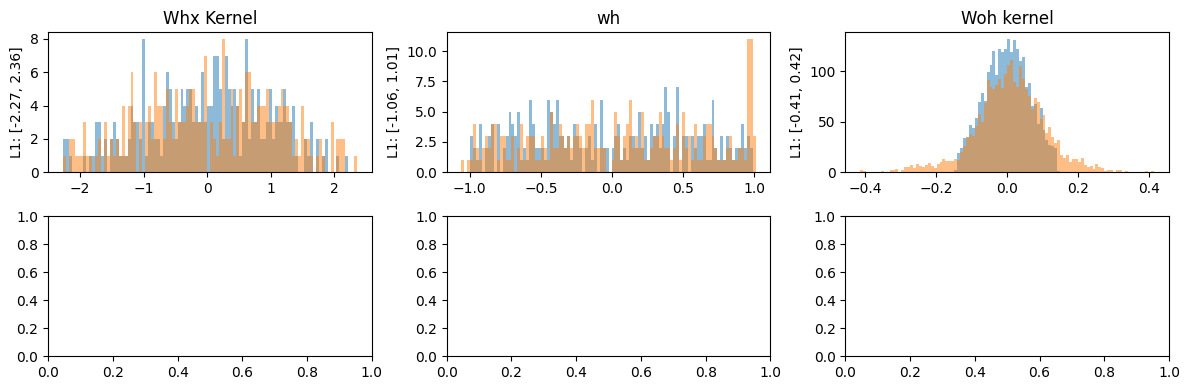

In [24]:
fig, axs = plt.subplots(len(all_state_hist)+1, 3, figsize=(1200*px, (300+100*len(all_state_hist))*px))
axs[0,0].set_title('Whx Kernel')
axs[0,1].set_title('wh')
axs[0,2].set_title('Woh kernel')
for l in range(len(all_state_hist)):
    min_whx_init = params['params'][f'rnn_cells_{l}']['Whx']['kernel'].min()
    min_whx = state.params[f'rnn_cells_{l}']['Whx']['kernel'].min()
    min_whx = min(min_whx_init, min_whx)

    min_wh_init = params['params'][f'rnn_cells_{l}']['wh'].min()
    min_wh = state.params[f'rnn_cells_{l}']['wh'].min()
    min_wh = min(min_wh_init, min_wh)

    min_woh_init = params['params'][f'readout']['kernel'].min()
    min_woh = state.params[f'readout']['kernel'].min()
    min_woh = min(min_woh_init, min_woh)

    max_whx_init = params['params'][f'rnn_cells_{l}']['Whx']['kernel'].max()
    max_whx = state.params[f'rnn_cells_{l}']['Whx']['kernel'].max()
    max_whx = max(max_whx_init, max_whx)

    max_wh_init = params['params'][f'rnn_cells_{l}']['wh'].max()
    max_wh = state.params[f'rnn_cells_{l}']['wh'].max()
    max_wh = max(max_wh_init, max_wh)

    max_woh_init = params['params'][f'readout']['kernel'].max()
    max_woh = state.params[f'readout']['kernel'].max()
    max_woh = max(max_woh_init, max_woh)



    axs[l,0].hist(params['params'][f'rnn_cells_{l}']['Whx']['kernel'].flatten(), bins=100, alpha=0.5, range=(min_whx, max_whx))
    axs[l,1].hist(params['params'][f'rnn_cells_{l}']['wh'].flatten(), bins=100, alpha=0.5, range=(min_wh, max_wh))
    axs[l,2].hist(params['params'][f'readout']['kernel'].flatten(), bins=100, alpha=0.5, range=(min_woh, max_woh))
    axs[l,0].hist(state.params[f'rnn_cells_{l}']['Whx']['kernel'].flatten(), bins=100, alpha=0.5, range=(min_whx, max_whx))
    axs[l,1].hist(state.params[f'rnn_cells_{l}']['wh'].flatten(), bins=100, alpha=0.5, range=(min_wh, max_wh))
    axs[l,2].hist(state.params[f'readout']['kernel'].flatten(), bins=100, alpha=0.5, range=(min_woh, max_woh))

    # y axis title
    axs[l,0].set_ylabel(f'L{l+1}: [{min_whx:.2f}, {max_whx:.2f}]')
    axs[l,1].set_ylabel(f'L{l+1}: [{min_wh:.2f}, {max_wh:.2f}]')
    axs[l,2].set_ylabel(f'L{l+1}: [{min_woh:.2f}, {max_woh:.2f}]')
    # set y range
plt.tight_layout()
plt.show()

In [25]:
jnp.min(params['params'][f'rnn_cells_{l}']['wh'])

Array(-0.986, dtype=float32)

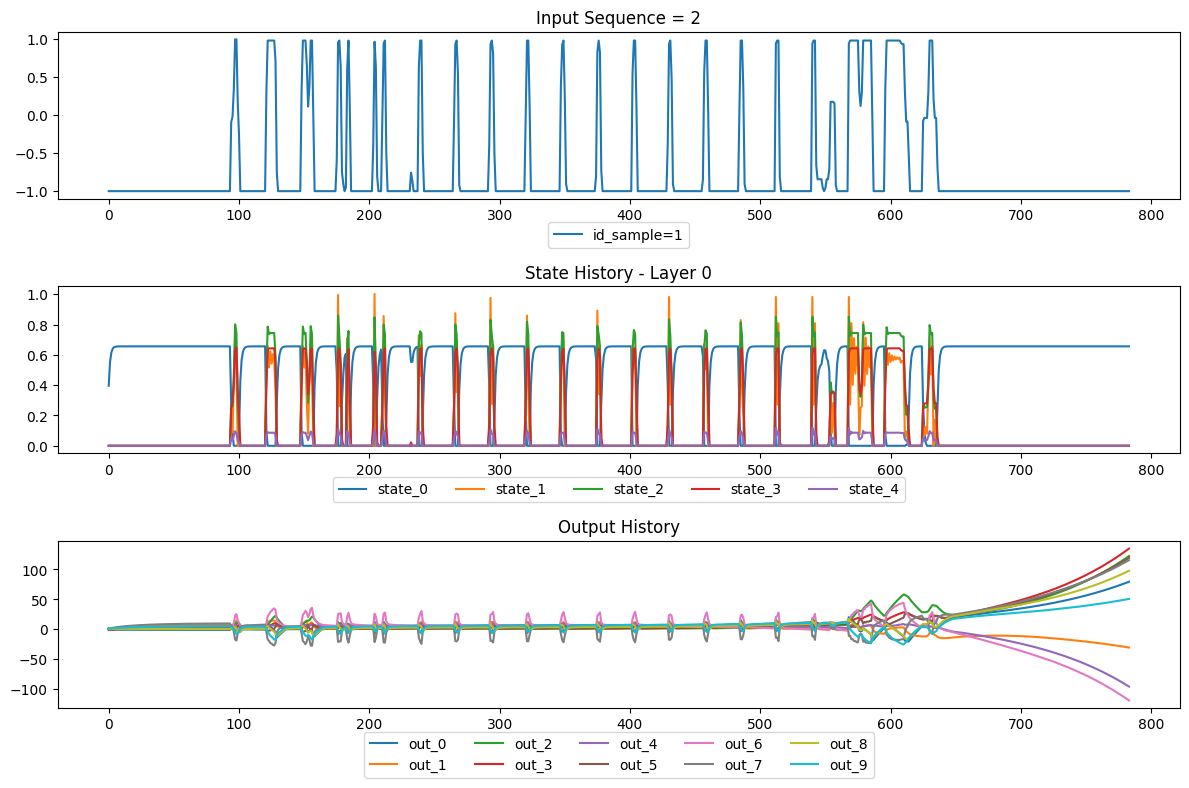

In [26]:
plot_dynamics(model, state.params, batch_x[:5], batch_y[:5], DATASET_VERSION,
              id_sample=1, nb_inputs_to_plot=5, nb_components_to_plot=5)

In [27]:
all_state_hist, out_hist = model.apply({'params':state.params}, batch_x[:5])

In [28]:
y = out_hist.mean(axis=1)
print(y.shape)
assert y.shape == (5, 10)
print(y)

(5, 10)
[[ 4.315  3.744  7.061  7.209  3.343  7.14   2.071  8.328  5.532  6.396]
 [ 9.739  0.079 16.441 15.876 -1.741 14.132 -1.917 12.669 11.689  8.206]
 [ 0.324  6.8    3.225  3.233  4.553  3.959  3.097  6.201  1.546  4.379]
 [ 9.214 -1.584  7.831  7.548  7.883  6.671  8.572  6.055  9.043  8.916]
 [ 1.678  5.578  3.067  2.747  5.729  2.933  6.062  3.294  2.469  4.215]]


In [29]:
one_hot = jax.nn.one_hot(batch_y[:5], 10)
loss = optax.softmax_cross_entropy(logits=y, labels=one_hot)
print(loss.shape)
print(loss)
print(loss.mean())

(5,)
[0.768 0.531 0.637 1.371 1.335]
0.92836726


# Multi Layer (3 hidden, 1 output) Diagonal ReLU Recurrent Network (Pachitariu 2013) to sMNIST/rowMNIST
## This code uses flax.linen.scan to speed up the loop over time

## Equations
The recurrent weights are now diagonal matrices, which means we can do hadamard products instead of matrix multiplications. These weights are sampled uniformly between -0.999 and 0.999 to ensure that the eigenvalues are less than 1. 

The input and output weights are still dense matrices sampled using LeCun normal initialization.

All biases are initialized to zero.

Initialization:

$
W_{hx}^1 \in \mathbb{R}^{n_h \times n_x} \text{ with } W_{hx}^1 \text{ sampled } \sim \mathcal{N}(0, \sqrt{\frac{1}{n_x}}) \\
W_{hx}^2, W_{hx}^3 \in \mathbb{R}^{n_h \times n_h} \text{ with } W_{hx}^2, W_{hx}^3 \text{ sampled } \sim \mathcal{N}(0, \sqrt{\frac{1}{n_h}}) \\
\vec{w}_{hh}^1, \vec{w}_{hh}^2, \vec{w}_{hh}^3\in \mathbb{R}^{n_h} \text{ with } \vec{w}_{hh}^1, \vec{w}_{hh}^2, \vec{w}_{hh}^3 \text{ sampled } \sim \mathcal{U}(0.999, -0.999) \\
\vec{b}_h^1, \vec{b}_h^2, \vec{b}_h^3 \in \mathbb{R}^{n_h} \\
W_{hy} \in \mathbb{R}^{n_y \times n_h} \text{ with } W_{hy} \text{ sampled } \sim \mathcal{N}(0, \sqrt{\frac{1}{n_h}}) \\
\vec{b}_o \in \mathbb{R}^{n_y} \\
$


State update:

$
\vec{h}_t^1 = \text{ReLU}(W_{hx}^1\vec{x}_t + \vec{w}_{hh}^1\odot\vec{h}_{t-1}^1 + \vec{b}_h^1) \text{ with }\vec{h}_t^1 \in \mathbb{R}^{n_h} \text{ and } \vec{x}_t \in \mathbb{R}^{n_x} \\
\vec{h}_t^2 = \text{ReLU}(W_{hx}^2\vec{h}_t^1 + \vec{w}_{hh}^2\odot\vec{h}_{t-1}^2 + \vec{b}_h^2) \text{ with }\vec{h}_t^2 \in \mathbb{R}^{n_h} \\
\vec{h}_t^3 = \text{ReLU}(W_{hx}^3\vec{h}_t^2 + \vec{w}_{hh}^3\odot\vec{h}_{t-1}^2 + \vec{b}_h^3) \text{ with }\vec{h}_t^3 \in \mathbb{R}^{n_h} \\
$

Output: mean of output over time (or cummulative sum of output over time):

$
\vec{o}_t = W_{hy}\vec{h}_t^3 + \vec{b}_o \\
\vec{o} = \frac{1}{T}\sum_{t=1}^{T}\vec{o}_t \\
\vec{y} = \text{softmax}(\vec{o}) \\
$

<font color='green'>THINGS SOLVED</font>
- exploding activations --> change the recurrent weight initialization to ensure |w| < 1 

<font color='red'>THINGS TO UNDERSTAND</font>
- why init in glorot using (256,) does not work? --> my own init function
- understand why getting the params in the layers doesn't work
- understand why not running on GPU


In [30]:
model = BatchRNN(256, 10, 3)
params = model.init(jax.random.PRNGKey(0), jnp.zeros_like(batch_x[:5]))

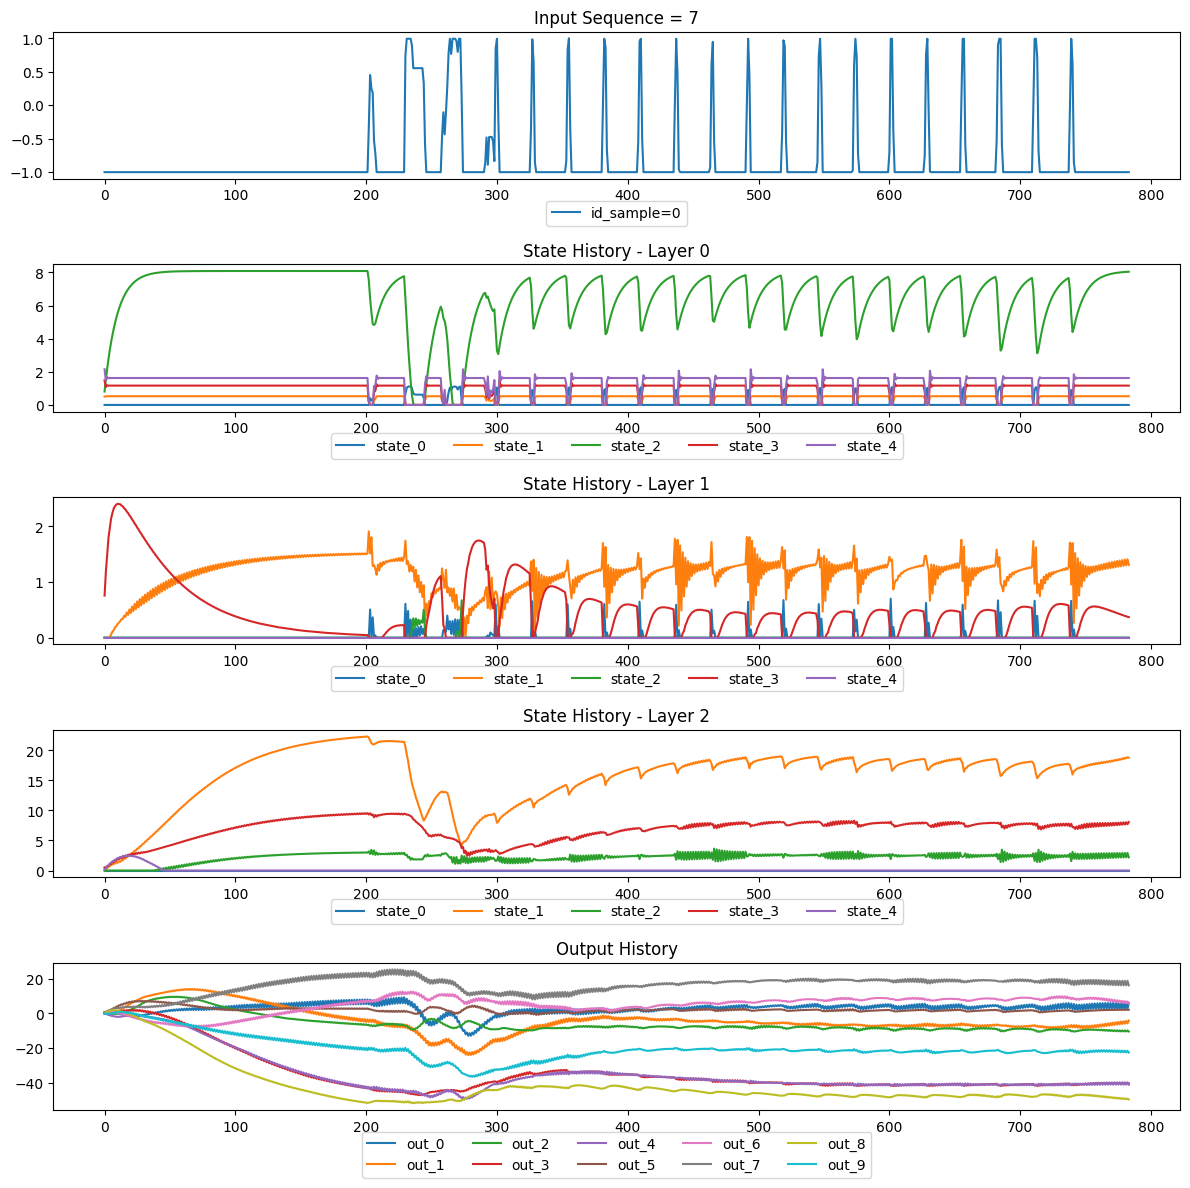

In [31]:
plot_dynamics(model, params, batch_x, batch_y, DATASET_VERSION, id_sample=0, nb_inputs_to_plot=5, nb_components_to_plot=5)

In [32]:
state = create_train_state(key, BatchRNN, lr, DATASET_VERSION, hidden_size=256, n_layers=3)

Initialized parameter structure: {'readout': {'bias': (10,), 'kernel': (256, 10)}, 'rnn_cells_0': {'Whx': {'bias': (256,), 'kernel': (1, 256)}, 'wh': (256,)}, 'rnn_cells_1': {'Whx': {'bias': (256,), 'kernel': (256, 256)}, 'wh': (256,)}, 'rnn_cells_2': {'Whx': {'bias': (256,), 'kernel': (256, 256)}, 'wh': (256,)}}
[*] Trainable Parameters: 135434


In [33]:
jax.devices()

[cuda(id=0)]

In [35]:
for epoch in range(5):
    state, train_loss, train_accuracy = run_epoch(state, trainloader, key)
    val_loss, val_acc  = validate(state, val_loader)
    print(f"Epoch {epoch} | train_loss: {train_loss:.4f} | train_acc: {train_accuracy*100:.2f}% | val_loss: {val_loss:.4f} | val_acc: {val_acc*100:.2f}%")

Training: 100%|██████████| 390/390 [00:28<00:00, 13.58it/s, accuracy=0.406, loss=1.76]


Epoch 0 | train_loss: 6.8655 | train_acc: 27.04% | val_loss: 1.7030 | val_acc: 41.33%


Training: 100%|██████████| 390/390 [00:28<00:00, 13.47it/s, accuracy=0.586, loss=1.22]


Epoch 1 | train_loss: 1.5775 | train_acc: 46.19% | val_loss: 1.2984 | val_acc: 57.81%


Training: 100%|██████████| 390/390 [00:29<00:00, 13.42it/s, accuracy=0.625, loss=1.12] 


Epoch 2 | train_loss: 1.2642 | train_acc: 56.97% | val_loss: 0.9963 | val_acc: 66.90%


Training: 100%|██████████| 390/390 [00:29<00:00, 13.43it/s, accuracy=0.695, loss=0.936]


Epoch 3 | train_loss: 0.9438 | train_acc: 67.85% | val_loss: 0.7772 | val_acc: 74.95%


Training: 100%|██████████| 390/390 [00:28<00:00, 13.50it/s, accuracy=0.781, loss=0.699]


Epoch 4 | train_loss: 0.7595 | train_acc: 74.40% | val_loss: 0.7431 | val_acc: 73.69%


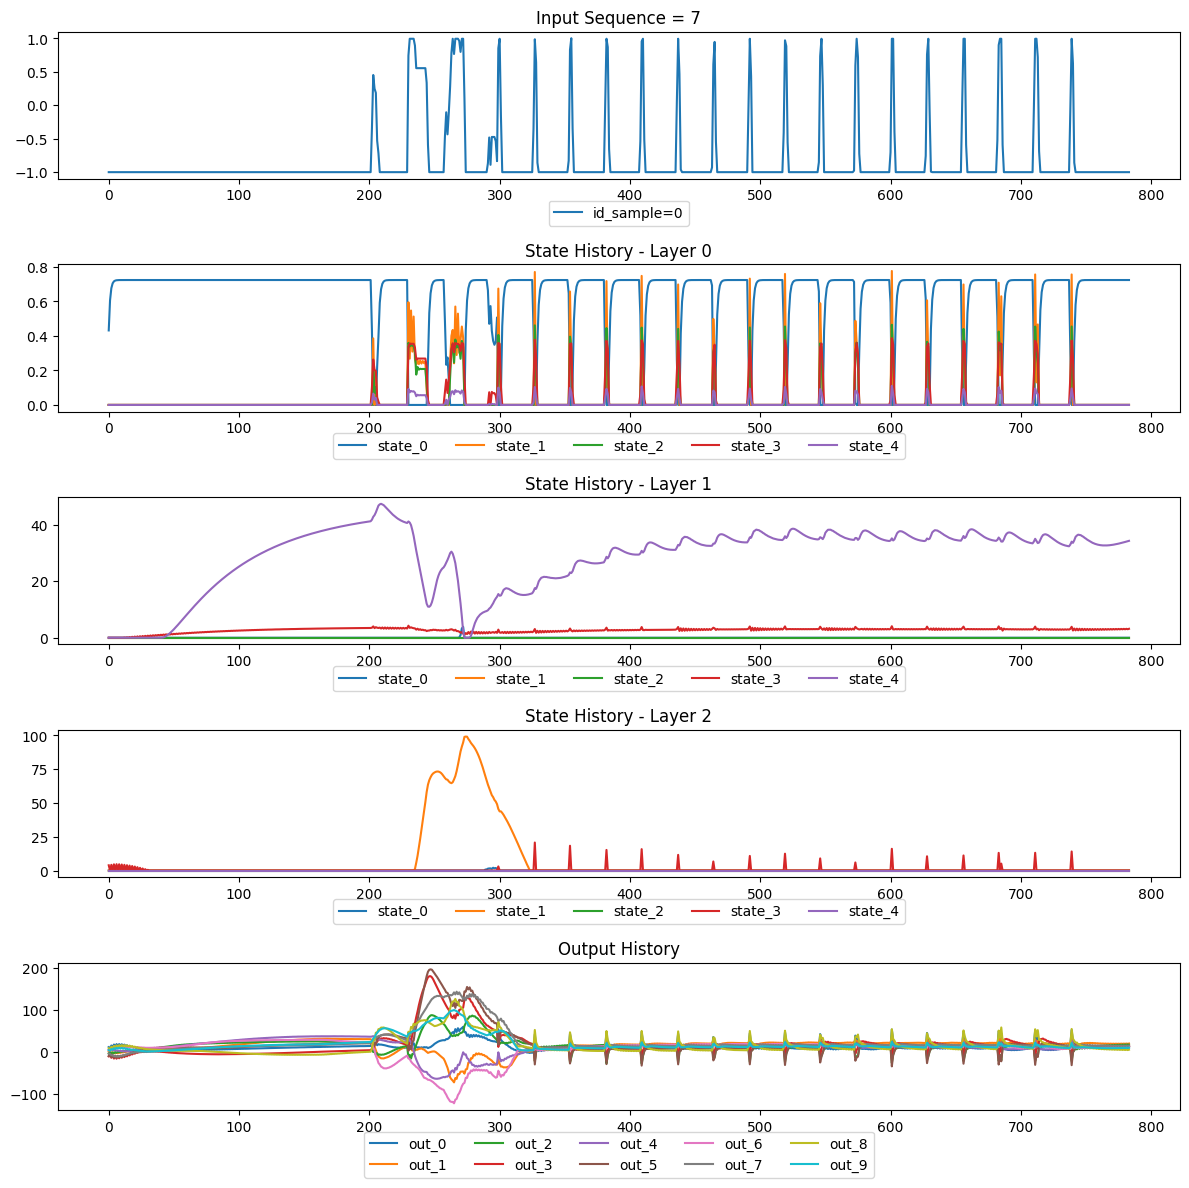

In [36]:
plot_dynamics(model, state.params, batch_x, batch_y, DATASET_VERSION, id_sample=0, nb_inputs_to_plot=5, nb_components_to_plot=5)

In [39]:
all_state_hist, out_hist = model.apply({'params':state.params}, batch_x[:5])

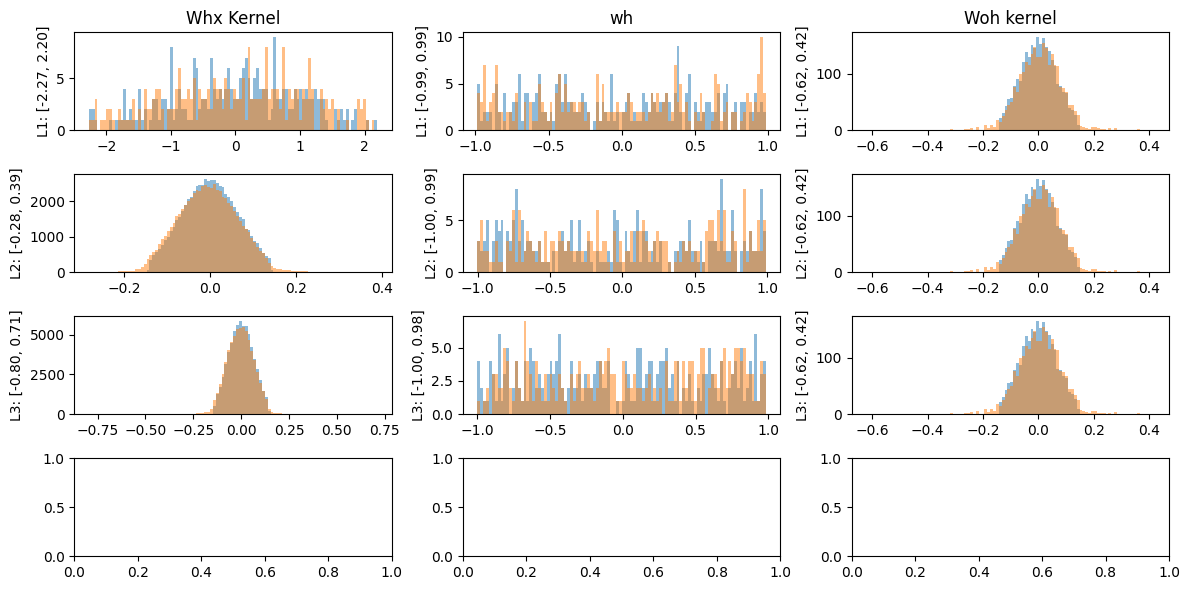

In [40]:
fig, axs = plt.subplots(len(all_state_hist)+1, 3, figsize=(1200*px, (300+100*len(all_state_hist))*px))
axs[0,0].set_title('Whx Kernel')
axs[0,1].set_title('wh')
axs[0,2].set_title('Woh kernel')
for l in range(len(all_state_hist)):
    min_whx_init = params['params'][f'rnn_cells_{l}']['Whx']['kernel'].min()
    min_whx = state.params[f'rnn_cells_{l}']['Whx']['kernel'].min()
    min_whx = min(min_whx_init, min_whx)

    min_wh_init = params['params'][f'rnn_cells_{l}']['wh'].min()
    min_wh = state.params[f'rnn_cells_{l}']['wh'].min()
    min_wh = min(min_wh_init, min_wh)

    min_woh_init = params['params'][f'readout']['kernel'].min()
    min_woh = state.params[f'readout']['kernel'].min()
    min_woh = min(min_woh_init, min_woh)

    max_whx_init = params['params'][f'rnn_cells_{l}']['Whx']['kernel'].max()
    max_whx = state.params[f'rnn_cells_{l}']['Whx']['kernel'].max()
    max_whx = max(max_whx_init, max_whx)

    max_wh_init = params['params'][f'rnn_cells_{l}']['wh'].max()
    max_wh = state.params[f'rnn_cells_{l}']['wh'].max()
    max_wh = max(max_wh_init, max_wh)

    max_woh_init = params['params'][f'readout']['kernel'].max()
    max_woh = state.params[f'readout']['kernel'].max()
    max_woh = max(max_woh_init, max_woh)



    axs[l,0].hist(params['params'][f'rnn_cells_{l}']['Whx']['kernel'].flatten(), bins=100, alpha=0.5, range=(min_whx, max_whx))
    axs[l,1].hist(params['params'][f'rnn_cells_{l}']['wh'].flatten(), bins=100, alpha=0.5, range=(min_wh, max_wh))
    axs[l,2].hist(params['params'][f'readout']['kernel'].flatten(), bins=100, alpha=0.5, range=(min_woh, max_woh))
    axs[l,0].hist(state.params[f'rnn_cells_{l}']['Whx']['kernel'].flatten(), bins=100, alpha=0.5, range=(min_whx, max_whx))
    axs[l,1].hist(state.params[f'rnn_cells_{l}']['wh'].flatten(), bins=100, alpha=0.5, range=(min_wh, max_wh))
    axs[l,2].hist(state.params[f'readout']['kernel'].flatten(), bins=100, alpha=0.5, range=(min_woh, max_woh))

    # y axis title
    axs[l,0].set_ylabel(f'L{l+1}: [{min_whx:.2f}, {max_whx:.2f}]')
    axs[l,1].set_ylabel(f'L{l+1}: [{min_wh:.2f}, {max_wh:.2f}]')
    axs[l,2].set_ylabel(f'L{l+1}: [{min_woh:.2f}, {max_woh:.2f}]')
    # set y range
plt.tight_layout()
plt.show()